In [2]:
import pandas as pd
import numpy as np
import os
import urllib.request as urllib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from fiona.crs import from_epsg
import networkx as nx
import osmnx as ox

## Download the File

In [24]:
url = 'https://s3.amazonaws.com/tripdata/201811-citibike-tripdata.csv.zip'
urllib.urlretrieve(url, '201811.zip')
!unzip 201811.zip

('201811.zip', <http.client.HTTPMessage at 0x296aa6a8fd0>)

In [3]:
data = pd.read_csv('201811-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,254,2018-11-01 00:00:12.9100,2018-11-01 00:04:27.3870,3522.0,37 St & 24 Ave,40.770148,-73.912094,3513.0,21 St & Hoyt Ave S,40.774645,-73.923706,34117,Subscriber,1992,1
1,833,2018-11-01 00:00:16.3440,2018-11-01 00:14:09.4320,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,251.0,Mott St & Prince St,40.723180,-73.994800,32569,Subscriber,1986,2
2,683,2018-11-01 00:00:17.6630,2018-11-01 00:11:40.9170,3405.0,5 St & 6 Ave,40.670484,-73.982090,3584.0,Eastern Pkwy & Franklin Ave,40.670777,-73.957680,15795,Subscriber,1985,1
3,1840,2018-11-01 00:00:18.7970,2018-11-01 00:30:59.3050,3150.0,E 85 St & York Ave,40.775369,-73.948034,297.0,E 15 St & 3 Ave,40.734232,-73.986923,33290,Subscriber,1994,1
4,1212,2018-11-01 00:00:47.3230,2018-11-01 00:20:59.8840,325.0,E 19 St & 3 Ave,40.736245,-73.984738,212.0,W 16 St & The High Line,40.743349,-74.006818,17411,Subscriber,1989,1


In [4]:
data.shape

(1260355, 15)

## Data Preprocessing

In [5]:
data = data[(data['gender'] != 0) & (data['tripduration'] <= 3000)].dropna()
data.reset_index(inplace = True)
data = data.drop(['index'], axis = 1)
data['starttime'] = data['starttime'].apply(pd.to_datetime)
data['stoptime'] = data['stoptime'].apply(pd.to_datetime)

cols = ['tripduration', 'start station id', 'start station latitude', 'start station longitude', 'end station id', \
        'end station latitude', 'end station longitude', 'bikeid', 'birth year', 'gender']
data[cols] = data[cols].apply(pd.to_numeric, axis=1)
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,254.0,2018-11-01 00:00:12.910,2018-11-01 00:04:27.387,3522.0,37 St & 24 Ave,40.770148,-73.912094,3513.0,21 St & Hoyt Ave S,40.774645,-73.923706,34117.0,Subscriber,1992.0,1.0
1,833.0,2018-11-01 00:00:16.344,2018-11-01 00:14:09.432,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,251.0,Mott St & Prince St,40.723180,-73.994800,32569.0,Subscriber,1986.0,2.0
2,683.0,2018-11-01 00:00:17.663,2018-11-01 00:11:40.917,3405.0,5 St & 6 Ave,40.670484,-73.982090,3584.0,Eastern Pkwy & Franklin Ave,40.670777,-73.957680,15795.0,Subscriber,1985.0,1.0
3,1840.0,2018-11-01 00:00:18.797,2018-11-01 00:30:59.305,3150.0,E 85 St & York Ave,40.775369,-73.948034,297.0,E 15 St & 3 Ave,40.734232,-73.986923,33290.0,Subscriber,1994.0,1.0
4,1212.0,2018-11-01 00:00:47.323,2018-11-01 00:20:59.884,325.0,E 19 St & 3 Ave,40.736245,-73.984738,212.0,W 16 St & The High Line,40.743349,-74.006818,17411.0,Subscriber,1989.0,1.0


In [95]:
data.shape

(1183673, 19)

## Some Basic Analysis and Plots

In [7]:
data[['tripduration', 'birth year', 'gender']].describe()

,tripduration,birth year,gender
count,1.183673e+06,1.183673e+06,1.183673e+06
mean,6.966886e+02,1.979820e+03,1.242601e+00
std,5.148980e+02,1.215134e+01,4.286558e-01
min,6.100000e+01,1.886000e+03,1.000000e+00
25%,3.310000e+02,1.971000e+03,1.000000e+00
50%,5.410000e+02,1.983000e+03,1.000000e+00
75%,9.040000e+02,1.989000e+03,1.000000e+00
max,3.000000e+03,2.002000e+03,2.000000e+00


Text(0.5,1,'Histogram of distribution of tripdurations of male riders')

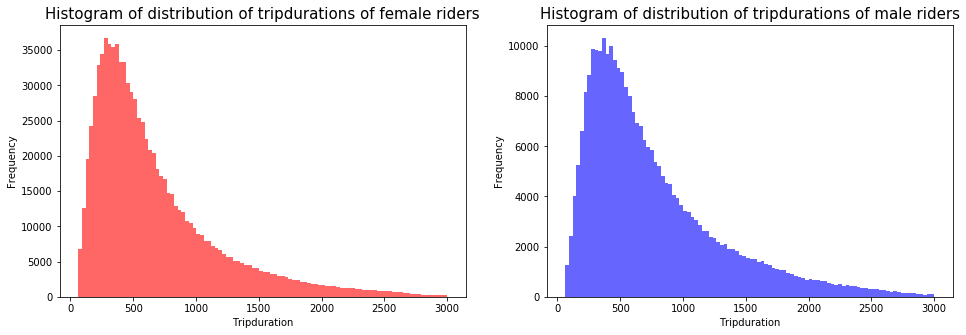

In [9]:
data_female = data[(data['gender'] == 1)]
data_male = data[(data['gender'] == 2)]

fig = plt.figure(figsize = (16,5))
ax = fig.add_subplot(121)
ax.hist(x = data_female['tripduration'], bins = 100, color = 'red', alpha = .6)
ax.set_xlabel('Tripduration')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of distribution of tripdurations of female riders', fontsize = 15)

ax = fig.add_subplot(122)
ax.hist(x = data_male['tripduration'], bins = 100, color = 'blue', alpha = .6)
ax.set_xlabel('Tripduration')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of distribution of tripdurations of male riders', fontsize = 15)

Text(0.5,1,'Barplot of average tripduration group by birth year and gender')

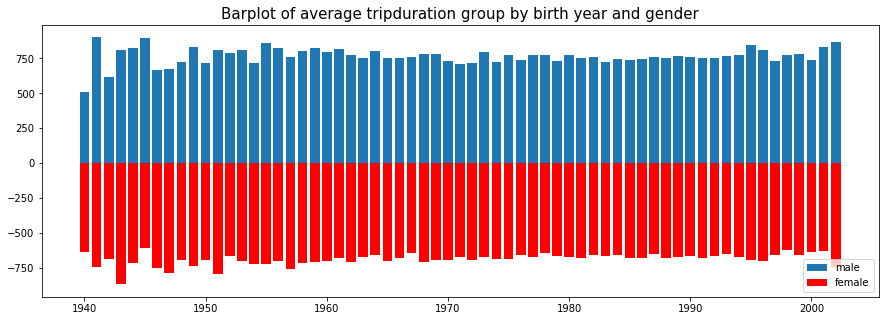

In [212]:
df_female = data[(data['gender'] == 1) & (data['birth year'] > 1939)].groupby(['birth year']).mean()
df_female.sort_values(by='tripduration', inplace = True)

df_male = data[(data['gender'] == 2) & (data['birth year'] > 1939)].groupby(['birth year']).mean()
df_male.sort_values(by='tripduration', inplace = True)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
ax.bar(df_male.index, df_male['tripduration'], label = 'male')
ax.bar(df_female.index, -df_female['tripduration'], color = 'r', label = 'female')
ax.legend()
ax.set_title('Barplot of average tripduration group by birth year and gender', fontsize = 15)

Text(0.5,1,'Barplot of 10 most popular bikeid')

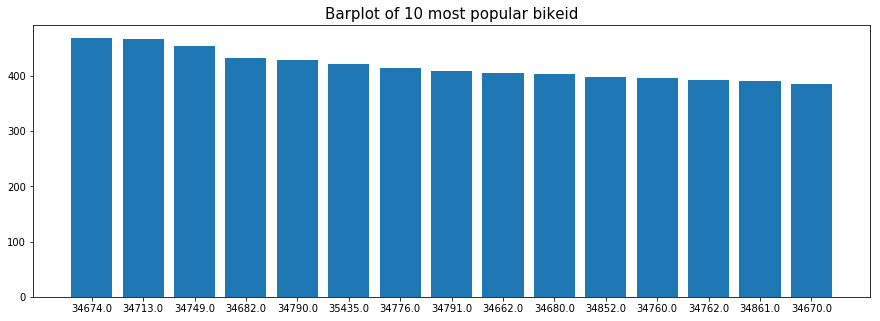

In [215]:
df = data.groupby(['bikeid']).count().sort_values(by = 'tripduration', ascending = False)
df.index = df.index.astype(str)
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
ax.bar(df[:15].index, df[:15]['tripduration'])
ax.set_title('Barplot of 10 most popular bikeid', fontsize = 15)

## Stations Analysis

In [36]:
def stationplot(column, ascending):
    df = data.groupby([column]).count()
    df.sort_values(by = 'tripduration', ascending = ascending, inplace = True)
    ax.bar(df[:10].index, df[:10]['tripduration'])
    if ascending == False:
        ax.set_title('Barplot of 10 most frequent {}'.format(column), fontsize = 15)
    else:
        ax.set_title('Barplot of 10 least frequent {}'.format(column), fontsize = 15)

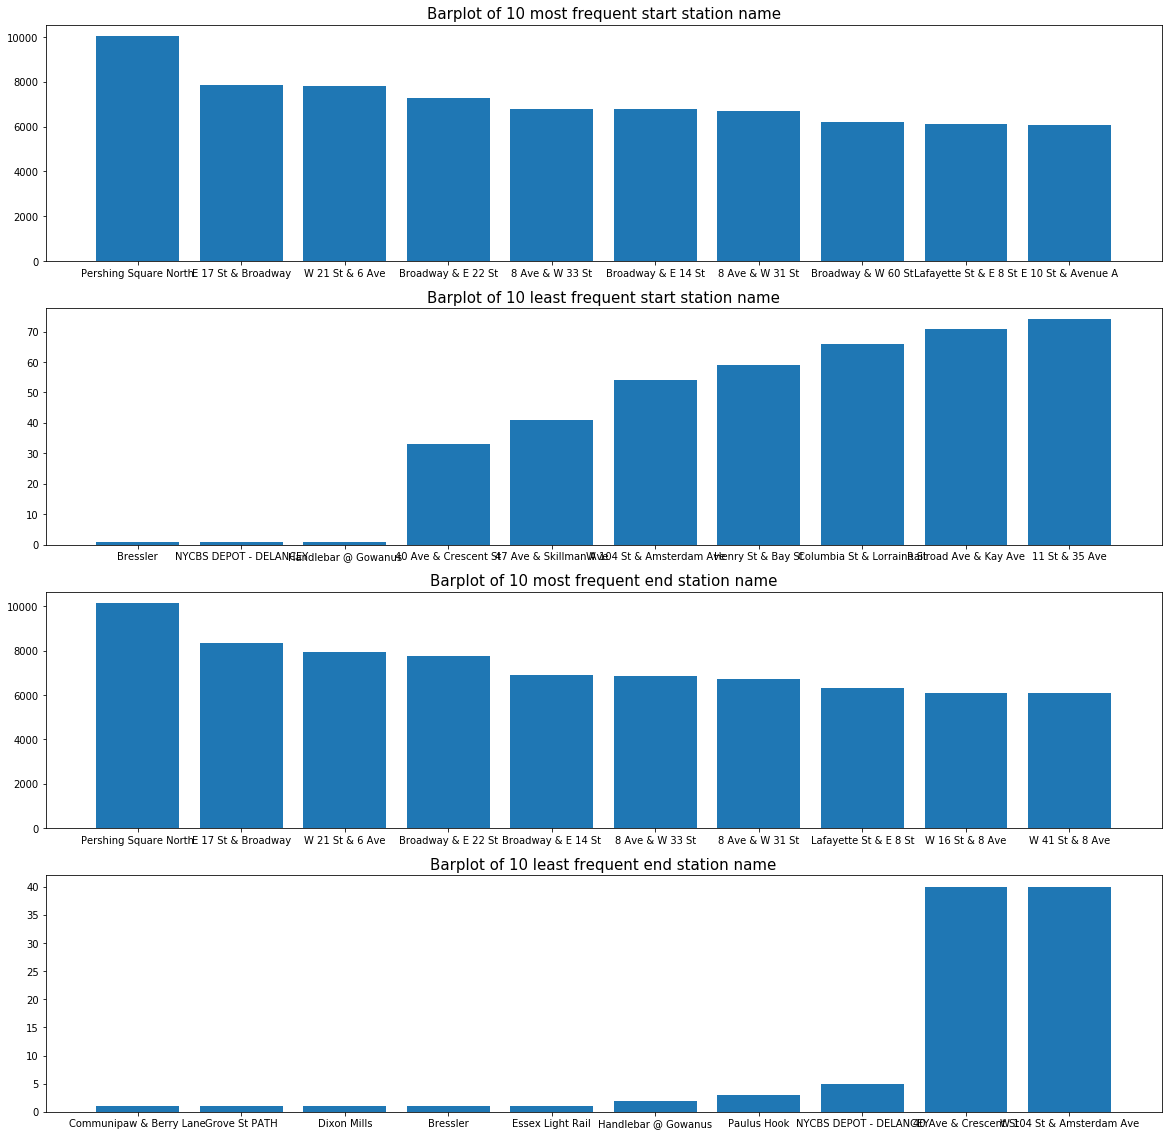

In [92]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(411)
stationplot('start station name', False)
ax = fig.add_subplot(412)
stationplot('start station name', True)
ax = fig.add_subplot(413)
stationplot('end station name', False)
ax = fig.add_subplot(414)
stationplot('end station name', True)

In [94]:
startlonlat = []
endlonlat = []
for i in range(len(data)):
    startlonlat.append([data['start station longitude'][i], data['start station latitude'][i]])
    endlonlat.append([data['end station longitude'][i], data['end station latitude'][i]])
data['startlonlat'] = startlonlat
data['endlonlat'] = endlonlat
data['startloc'] = data[['startlonlat']].applymap(lambda x: Point(x))
data['endloc'] = data[['endlonlat']].applymap(lambda x: Point(x))
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,startlonlat,endlonlat,startloc,endloc
0,254.0,2018-11-01 00:00:12.910,2018-11-01 00:04:27.387,3522.0,37 St & 24 Ave,40.770148,-73.912094,3513.0,21 St & Hoyt Ave S,40.774645,-73.923706,34117.0,Subscriber,1992.0,1.0,"[-73.9120938, 40.7701477]","[-73.92370600000001, 40.774645]",POINT (-73.91209379999999 40.7701477),POINT (-73.92370600000001 40.774645)
1,833.0,2018-11-01 00:00:16.344,2018-11-01 00:14:09.432,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,251.0,Mott St & Prince St,40.723180,-73.994800,32569.0,Subscriber,1986.0,2.0,"[-73.99852205, 40.73226398]","[-73.99480012, 40.72317958]",POINT (-73.99852205000001 40.73226398),POINT (-73.99480011999999 40.72317958)
2,683.0,2018-11-01 00:00:17.663,2018-11-01 00:11:40.917,3405.0,5 St & 6 Ave,40.670484,-73.982090,3584.0,Eastern Pkwy & Franklin Ave,40.670777,-73.957680,15795.0,Subscriber,1985.0,1.0,"[-73.98208968, 40.670483600000004]","[-73.9576801, 40.670776700000005]",POINT (-73.98208968 40.6704836),POINT (-73.9576801 40.6707767)
3,1840.0,2018-11-01 00:00:18.797,2018-11-01 00:30:59.305,3150.0,E 85 St & York Ave,40.775369,-73.948034,297.0,E 15 St & 3 Ave,40.734232,-73.986923,33290.0,Subscriber,1994.0,1.0,"[-73.94803392, 40.77536905]","[-73.986923, 40.734232]",POINT (-73.94803392 40.77536905),POINT (-73.986923 40.734232)
4,1212.0,2018-11-01 00:00:47.323,2018-11-01 00:20:59.884,325.0,E 19 St & 3 Ave,40.736245,-73.984738,212.0,W 16 St & The High Line,40.743349,-74.006818,17411.0,Subscriber,1989.0,1.0,"[-73.98473765, 40.73624527]","[-74.00681753, 40.74334935]",POINT (-73.98473765 40.73624527),POINT (-74.00681753000001 40.74334935)


Text(0.5,1,'end stations')

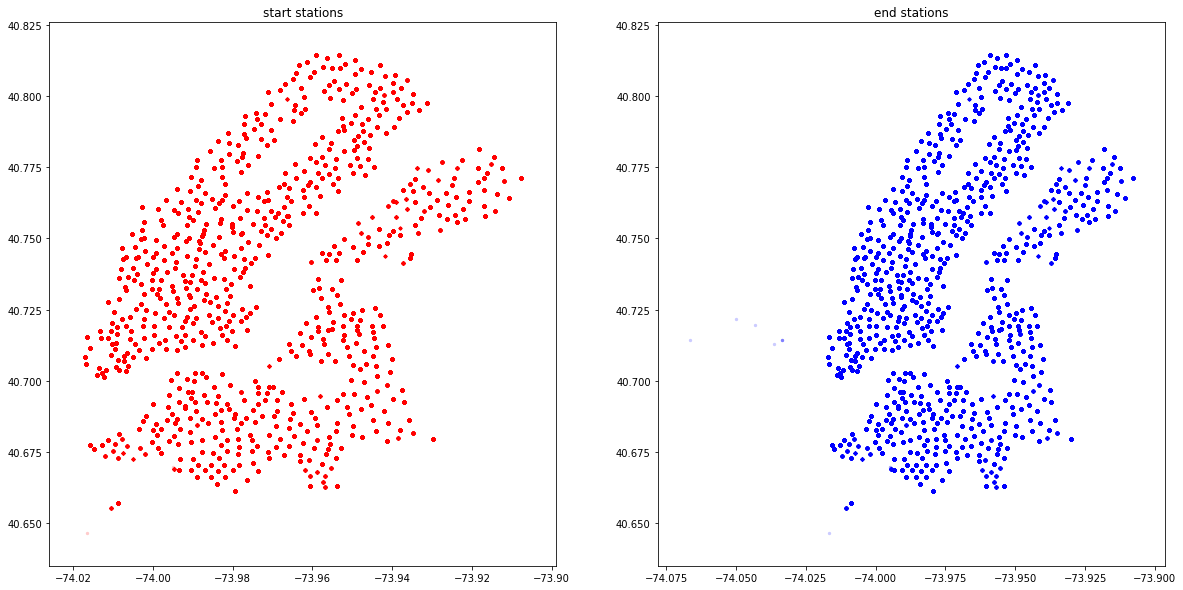

In [96]:
geostart = gpd.GeoDataFrame(data)
geoend = gpd.GeoDataFrame(data)
geostart.rename(columns = {'startloc': 'geometry'}, inplace = True)
geoend.rename(columns = {'endloc': 'geometry'}, inplace = True)
geostart.crs = from_epsg(code=4326)
geoend.crs = from_epsg(code=4326)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
geostart.plot(column=None, color="r", linewidth=0.1, alpha = .2, marker = 'o', markersize=10, ax=ax)
ax.set_title('start stations')
ax = fig.add_subplot(122)
geoend.plot(column=None, color="g", linewidth=0.1, alpha = .2, marker = 'o', markersize=10, ax=ax)
ax.set_title('end stations')

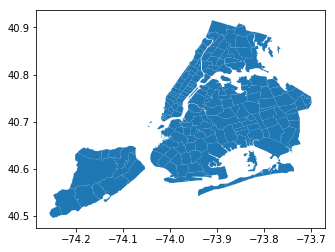

In [98]:
NYCzip = gpd.read_file('NY.shp')
NYCzip.plot(column=None)

Text(0.5,1,'end stations')

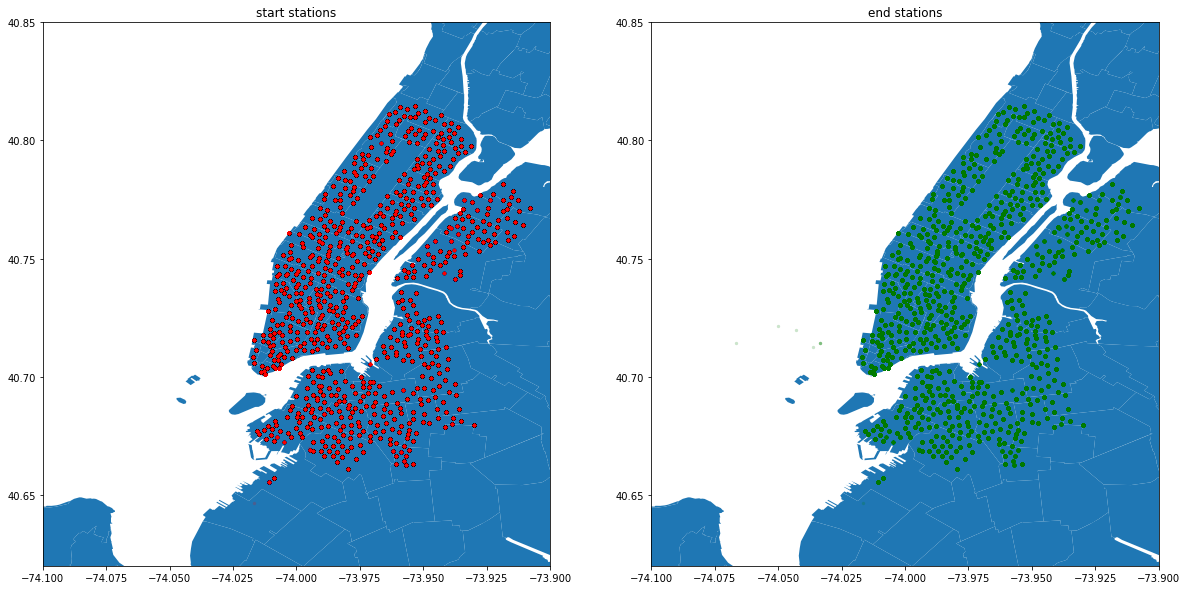

In [129]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
geostart.plot(column=None, color="r", linewidth=0.1, alpha = .2, markersize=10, ax=ax)
ax.set_title('start stations')

ax = fig.add_subplot(122)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
geoend.plot(column=None, color="g", linewidth=0.1, alpha = .2, markersize=10, ax=ax)
ax.set_title('end stations')

In [120]:
mstart = list(data.groupby(['start station name']).count().sort_values(by = 'tripduration', ascending = False)[:5].index)
lstart = list(data.groupby(['start station name']).count().sort_values(by = 'tripduration', ascending = True)[:5].index)
mend = list(data.groupby(['end station name']).count().sort_values(by = 'tripduration', ascending = False)[:5].index)
lend = list(data.groupby(['end station name']).count().sort_values(by = 'tripduration', ascending = True)[:5].index)

mstart

['Pershing Square North',
 'E 17 St & Broadway',
 'W 21 St & 6 Ave',
 'Broadway & E 22 St',
 '8 Ave & W 33 St']

Text(0.5,1,'start stations')

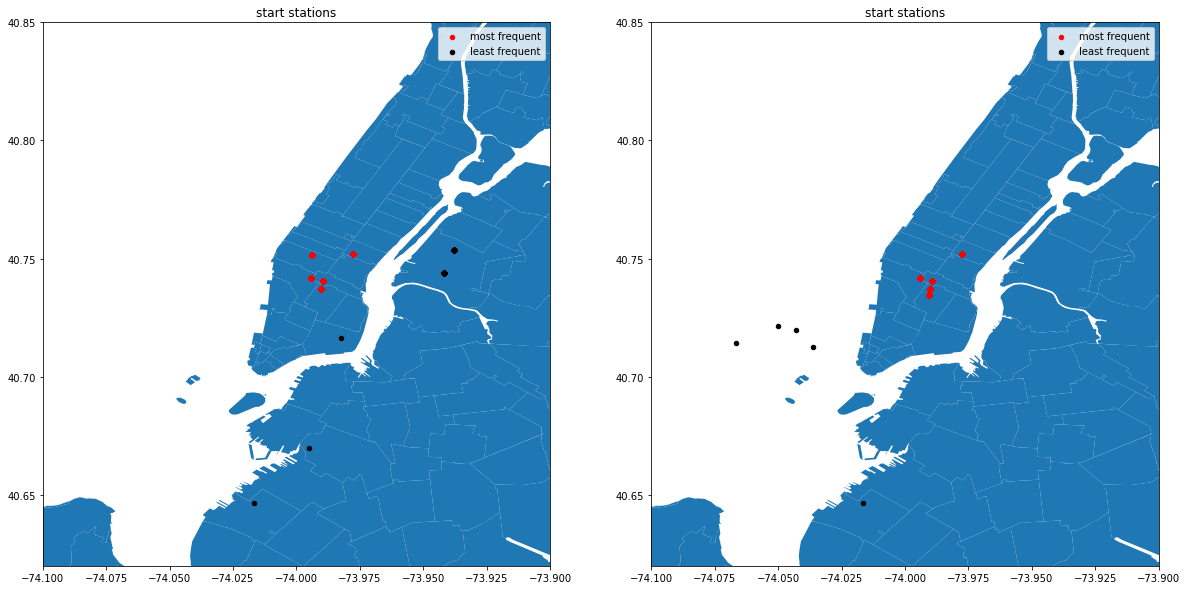

In [128]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
geostart[geostart['start station name'].isin(mstart)].plot(column=None, color="r", markersize=20, ax=ax, label = 'most frequent')
geostart[geostart['start station name'].isin(lstart)].plot(column=None, color="k", markersize=20, ax=ax, label = 'least frequent')
ax.legend()
ax.set_title('start stations', fontsize = 15)

ax = fig.add_subplot(122)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
geoend[geoend['end station name'].isin(mend)].plot(column=None, color="r", markersize=20, ax=ax, label = 'most frequent')
geoend[geoend['end station name'].isin(lend)].plot(column=None, color="k", markersize=20, ax=ax, label = 'least frequent')
ax.legend()
ax.set_title('end stations', fontsize = 15)

In [130]:
df_startstations = data[['start station id', 'start station name', 'start station longitude', 'start station latitude']].rename(columns = {'start station id':'station id', 'start station name':'station', 'start station longitude':'lon', 'start station latitude':'lat'})
df_endstations = data[['end station id', 'end station name', 'end station longitude', 'end station latitude']].rename(columns = {'end station id':'station id', 'end station name':'station', 'end station longitude':'lon', 'end station latitude':'lat'})
df_stations = pd.concat([df_startstations, df_endstations])
df_stations.drop_duplicates(subset = 'station', keep = 'first', inplace = True)
df_stations.set_index('station id', inplace = True)
df_stations.head()

,station,lon,lat
station id,,,
3522.0,37 St & 24 Ave,-73.912094,40.770148
252.0,MacDougal St & Washington Sq,-73.998522,40.732264
3405.0,5 St & 6 Ave,-73.982090,40.670484
3150.0,E 85 St & York Ave,-73.948034,40.775369
325.0,E 19 St & 3 Ave,-73.984738,40.736245


Text(0.5,1,'All Station Positions')

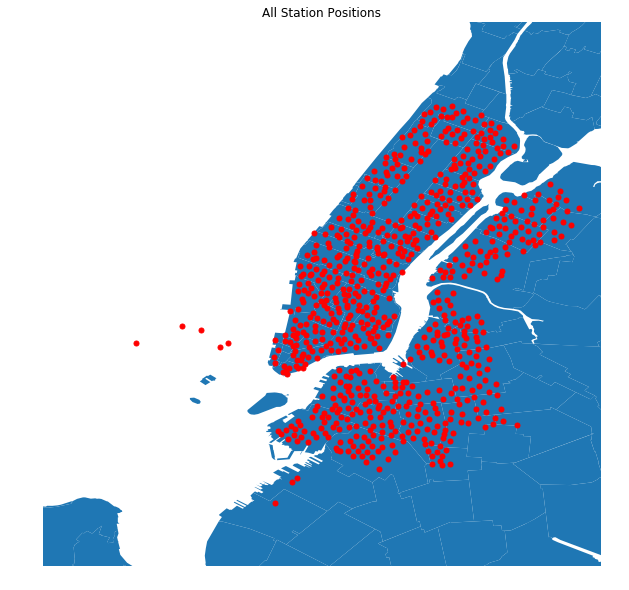

In [193]:
station = nx.Graph()
station.add_nodes_from(df_stations.index)
stationPos={i:(df_stations['lon'][i], df_stations['lat'][i]) for i in df_stations.index}

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
nx.draw(station,pos=stationPos,with_labels=False,arrows=False,node_size=25)
plt.title('All Station Positions')

Text(0.5,1,'Station Connections of first 10000 samples')

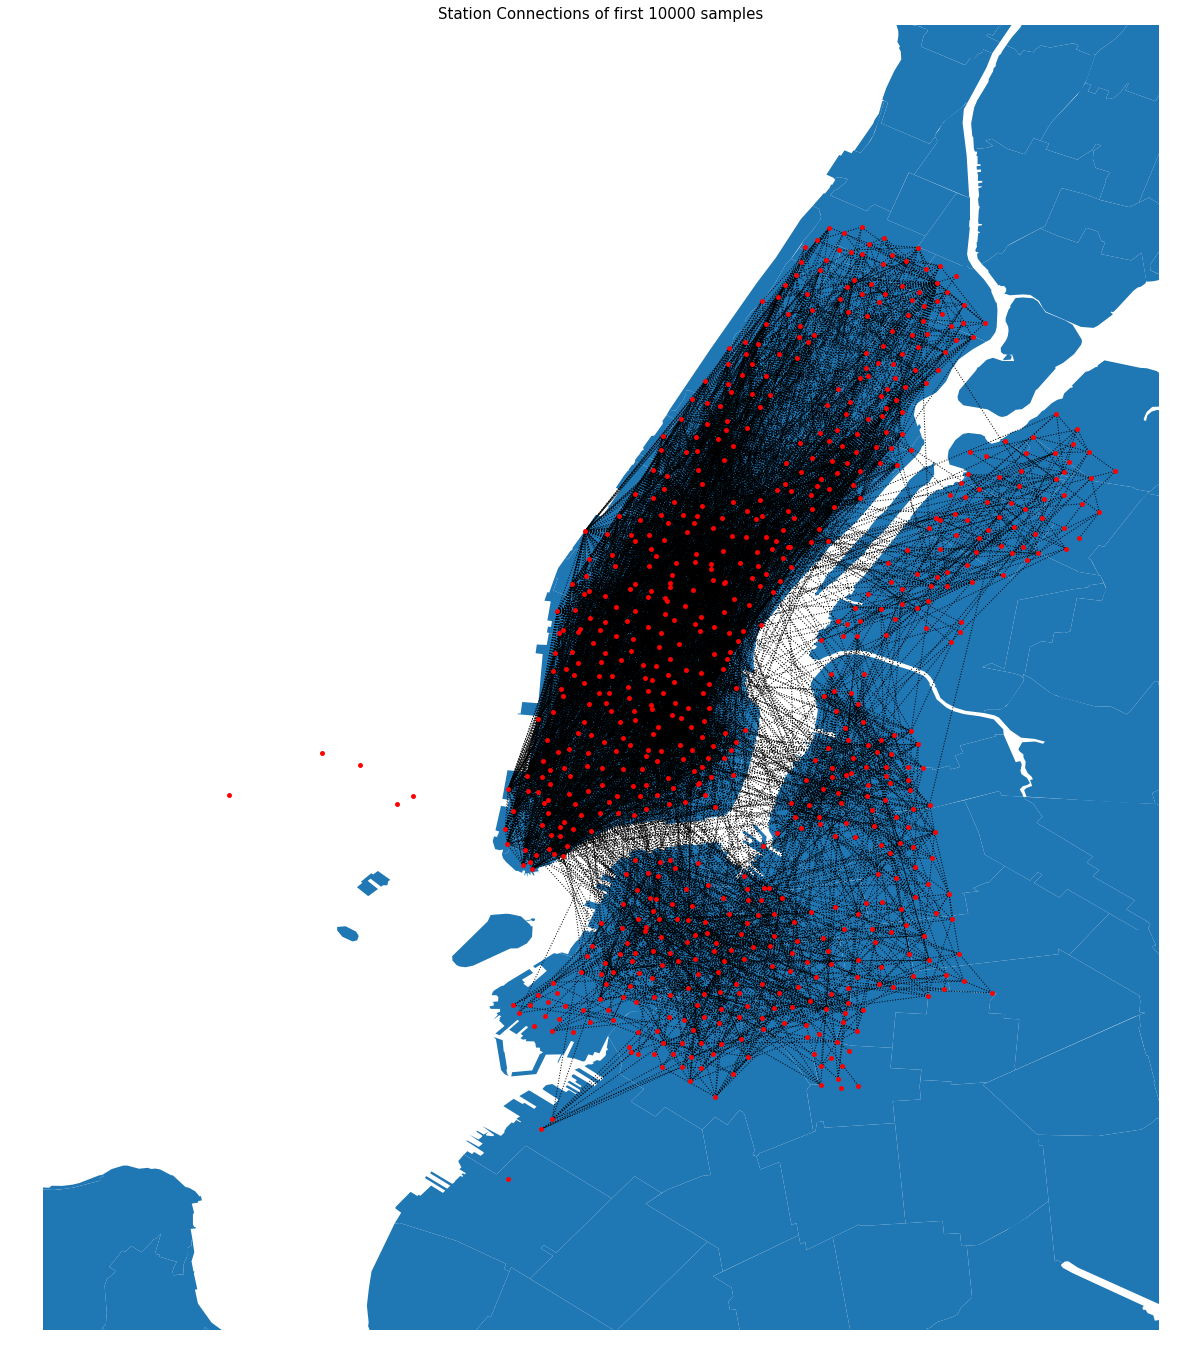

In [195]:
N = len(range(10000))
edgelist=[(data['start station id'][j],data['end station id'][j]) for j in range(N)]
station.add_edges_from(edgelist)

fig = plt.figure(figsize = (20,24))
ax = fig.add_subplot(111)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
nx.draw(station,pos=stationPos,with_labels=False,node_size=15,style='dotted', edge_color='k')
ax.set_title('Station Connections of first 10000 samples', fontsize = 15)

In [181]:
N = len(data)
edgelist=[(data['start station id'][j],data['end station id'][j]) for j in range(N)]
station.add_edges_from(edgelist)

In [182]:
stationDeg=dict(station.degree())
maximum = max(stationDeg, key=stationDeg.get)
minimum = min(stationDeg, key=stationDeg.get)
print('Most connected station is {0} with {1} connections'.format(df_stations.loc[maximum]['station'],stationDeg[maximum]))
print('Least connected station is {0} with {1} connections'.format(df_stations.loc[minimum]['station'],stationDeg[minimum]))

Most connected station is E 17 St & Broadway with 496 connections
Least connected station is Essex Light Rail with 1 connections


In [188]:
m = []
l = []
for i in range(5):
    m.append(sorted(stationDeg.items(), key=lambda x:x[1], reverse=True)[:5][i][0])
    l.append(sorted(stationDeg.items(), key=lambda x:x[1])[:5][i][0])

In [189]:
m

[497.0, 519.0, 402.0, 229.0, 285.0]

Text(0.5,1,'Most and Least Connected Stations')

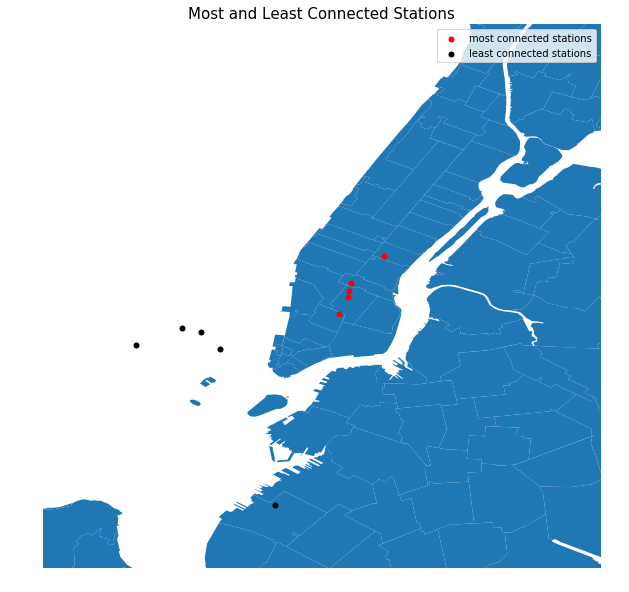

In [204]:
station2 = nx.Graph()
df_stations2 = df_stations[df_stations.index.isin(m)]
station2.add_nodes_from(df_stations2.index)
stationPos2={i:(df_stations2['lon'][i], df_stations2['lat'][i]) for i in df_stations2.index}

station3 = nx.Graph()
df_stations3 = df_stations[df_stations.index.isin(l)]
station3.add_nodes_from(df_stations3.index)
stationPos3={i:(df_stations3['lon'][i], df_stations3['lat'][i]) for i in df_stations3.index}

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
nx.draw(station2,pos=stationPos2,with_labels=False,arrows=False,node_size=25, label = 'most connected stations')
nx.draw(station3,pos=stationPos3,with_labels=False,arrows=False,node_size=25, node_color = 'k', label = 'least connected stations')
ax.legend()
ax.set_title('Most and Least Connected Stations', fontsize = 15)

Text(0.5,1,'Most and Least Connected Stations')

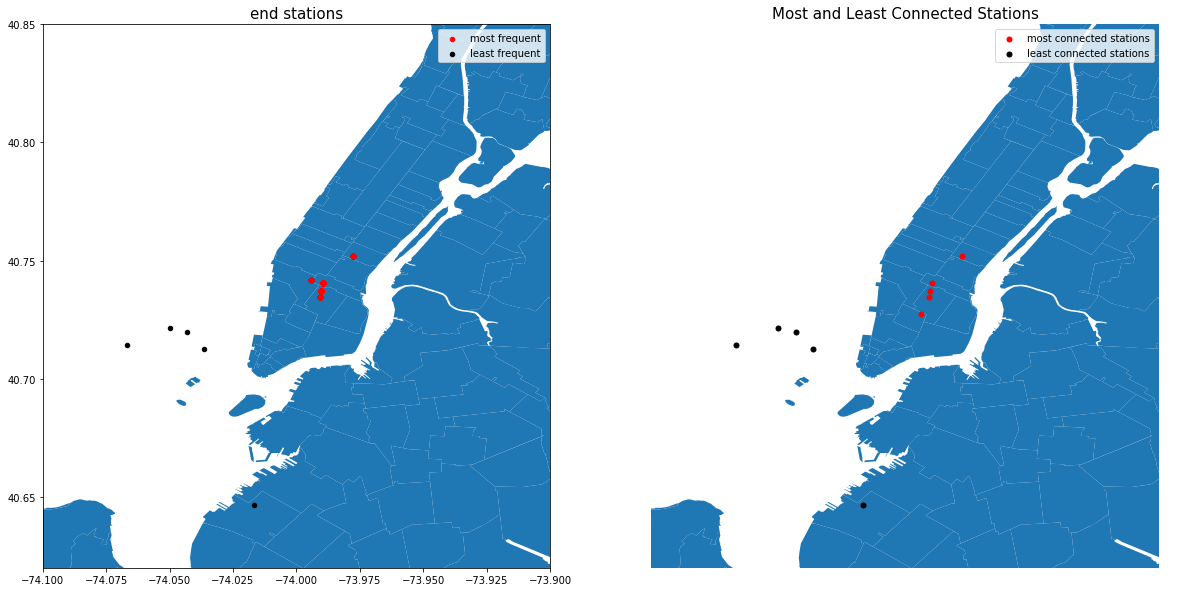

In [205]:
fig = fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(121)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
geoend[geoend['end station name'].isin(mend)].plot(column=None, color="r", markersize=20, ax=ax, label = 'most frequent')
geoend[geoend['end station name'].isin(lend)].plot(column=None, color="k", markersize=20, ax=ax, label = 'least frequent')
ax.legend()
ax.set_title('end stations', fontsize = 15)

ax = fig.add_subplot(122)
ax.set_xlim(-74.1,-73.9)
ax.set_ylim(40.62, 40.85)
NYCzip.plot(column=None, ax=ax)
nx.draw(station2,pos=stationPos2,with_labels=False,arrows=False,node_size=25, label = 'most connected stations')
nx.draw(station3,pos=stationPos3,with_labels=False,arrows=False,node_size=25, node_color = 'k', label = 'least connected stations')
ax.legend()
ax.set_title('Most and Least Connected Stations', fontsize = 15)

### We can see the results, especially the pattern of least frequent and least connected stations, are similar.

In [206]:
data.groupby(['start station name', 'end station name']).size().sort_values(ascending = False)

start station name             end station name                   
E 7 St & Avenue A              Cooper Square & Astor Pl               599
W 21 St & 6 Ave                9 Ave & W 22 St                        437
E 10 St & Avenue A             Lafayette St & E 8 St                  420
DeKalb Ave & Vanderbilt Ave    DeKalb Ave & Hudson Ave                358
N 6 St & Bedford Ave           S 4 St & Wythe Ave                     332
North Moore St & Greenwich St  Vesey Pl & River Terrace               331
W 26 St & 8 Ave                W 27 St & 10 Ave                       328
W 22 St & 10 Ave               W 22 St & 8 Ave                        327
W 16 St & 8 Ave                W 20 St & 11 Ave                       318
E 32 St & Park Ave             E 33 St & 1 Ave                        315
                               2 Ave & E 31 St                        313
Pershing Square North          E 24 St & Park Ave S                   310
Willoughby St & Fleet St       Adelphi St & M

In [207]:
data[data['start station name']=='E 7 St & Avenue A']['startlonlat'].head(1)

178    [-73.98379855, 40.72621788]
Name: startlonlat, dtype: object

In [208]:
data[data['end station name']=='Cooper Square & Astor Pl']['endlonlat'].head(1)

429    [-73.99075269699097, 40.729514962249496]
Name: endlonlat, dtype: object

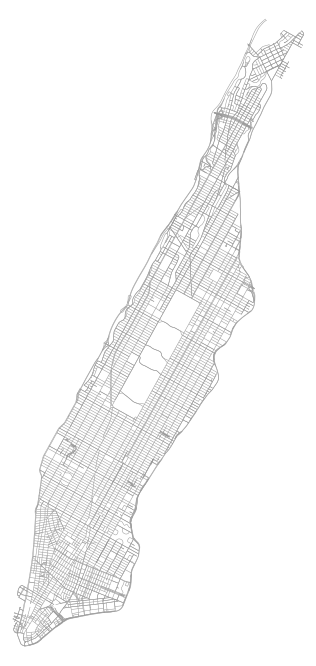

In [209]:
place = {'city' : 'Manhattan',
         'state' : 'New York',
         'country' : 'USA'}
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=12, node_size=0, edge_linewidth=0.5)

In [210]:
orig_node = ox.get_nearest_node(G, (-73.98379855, 40.72621788), return_dist=True)
dest_node = ox.get_nearest_node(G, (-73.99075269699097, 40.729514962249496), return_dist=True)

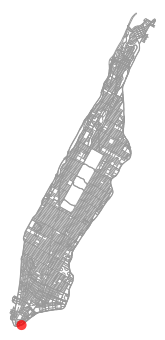

0

In [211]:
route = nx.shortest_path(G, orig_node[0], dest_node[0], weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)
nx.shortest_path_length(G, orig_node[0], dest_node[0], weight='length')